# 02477 Bayesian Machine Learning - Exercise 13

In [1]:
import autograd.numpy as np
import pylab as plt
import seaborn as snb
import time

from autograd.misc.optimizers import adam
from autograd.scipy.special import logsumexp
from autograd import grad
from autograd import hessian
from autograd.misc import flatten

from nn import NeuralNetwork

# style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.5)

### Overview

In this exercise we will study Bayesian-inspired methods for deep learning. The exercise is divided into the following parts:

- Part 0: Introduction and theory

- Part 1: Fitting a neural network to a toy problem with MAP-inference

- Part 2: Last layer Laplace approximations (LLLA)

- Part 3: Deep ensembles (DE)

- Part 4: Modelling the Concrete dataset from the UCI repository.



### Part 0: Introduction and theory

In this exercise, we will explore Bayesian-inspired methods for deep learning. The core concept in Bayesian methods is to compute weighted averages wrt. the posterior distribution of the parameters instead of betting everything on a single set of parameters. We will focus on supervised learning with probabilistic models of the form

\begin{align*}
p(\mathbf{t}, \mathbf{w}) = \prod_{n=1}^N p(t_n|\mathbf{w})p(\mathbf{w}) \tag{1},
\end{align*}

where $p(t_n|\mathbf{w})$ is the likelihood for the $n$-th observation, which is parametrized by a neural network with parameters $\mathbf{w}$. Ideally, we would like to compute the posterior distribution $p(\mathbf{w}|\mathbf{t})$ and use this to compute the posterior predictive distribution, but this is generally a very difficult task for neural network models due to the high-dimensional nature of the models, the complexity posterior geometry, and modern large datasets. 

In Bayesian deep learning, we aim to find a tractable approximation $q(\mathbf{w})$ such that we can approximate the posterior predictive distribution for a new point $t^*$ as follows

\begin{align*}
p(t^*|\mathbf{t}, \mathbf{x}^*) \approx \int p(t^*|\mathbf{w}, \mathbf{x}^*) q(\mathbf{w}) \text{d}\mathbf{w} \tag{2}.
\end{align*}

For example, for Laplace approximations and Gaussian variational approximations, we have $q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{V})$ and the integral in eq. (2) can be approximated using Monte Carlo sampling 

\begin{align*}
p(t^*|\mathbf{t}, \mathbf{x}^*) \approx \frac{1}{S} \sum_{i=1}^S p(t^*|\mathbf{w}^{(i)}, \mathbf{x}^*), \quad\quad\text{where}\quad\quad \mathbf{w}^{(i)} \sim  q(\mathbf{w}) \tag{3}.
\end{align*}

When the posterior approximation is Gaussian, there exists convenient closed for approximations for eq. (3) for some likelihoods (e.g.  like the probit-approximation for Bernoulli likelioods), so that Monte Carlo-estimation can be avoided in these cases. But for general likelihoods, we can always fall back to Monte Carlo estimation, which we will use here.

***Deep Ensembles***

An alternative to Gaussian posterior approximations is **Deep Ensembles** (DE), where we simply fit our model $S$-times from different seeds and treat the resulting parameters vectors $\mathbf{w}^{(i)}$ for $i = 1, \dots, S$ as pseudo-Monte Carlo samples corresponding to a posterior approximation of the form $q_{\text{DE}}(\mathbf{w}) = \frac{1}{S}\sum_{i=1}^S \delta(\mathbf{w}-\mathbf{w}^{(i)})$,
where $\delta(\cdot)$ is Dirac's delta function. Thus, for deep ensembles, we approximate the posterior predictive distribution as follows

\begin{align*}
p(t^*|\mathbf{t}, \mathbf{x}^*) \approx \int p(t^*|\mathbf{w}, \mathbf{x}^*) q_{\text{DE}}(\mathbf{w}) \text{d}\mathbf{w} = \frac{1}{S}\sum_{i=1}^S  p(t^*|\mathbf{w}^{(i)}, \mathbf{x}^*). \tag{4}
\end{align*}

MAP-inference is equivalent to a "degenerate" deep ensemble with $S = 1$ and therefore, we can think of MAP-inference as approximate posterior inference with the degenerate approximation $q_{\text{MAP}}(\mathbf{w}) = \delta(\mathbf{w}- \mathbf{w}_{\text{MAP}})$:

\begin{align*}
p(t^*|\mathbf{t}, \mathbf{x}^*) \approx \int p(t^*|\mathbf{w}, \mathbf{x}^*) q_{\text{MAP}}(\mathbf{w}) \text{d}\mathbf{w} = p(t^*|\mathbf{w}_{\text{MAP}}, \mathbf{x}^*). \tag{4b}
\end{align*}

**Non-linear regression with heteroscedastic noise**

In this exercise, we will study regression models with Gaussian likelihoods of the form

\begin{align*}
    p(t_n|\mathbf{w}) = \mathcal{N}(t_n|\mu_{\mathbf{w}}(\mathbf{x}_n), \sigma^2_{\mathbf{w}}(\mathbf{x}_n)). \tag{5}
\end{align*}

In this model, we assume *heteroscedasticity*, i.e. we allow the noise variance of the observations to depend on the input $\mathbf{x}$. This should be contrasted with *homoscedastic models*, where the noise variance is assumed to be constant, i.e. $\sigma^2(\mathbf{x}_n) = \sigma^2_0$. 

We will parameterize this likelihood using a neural network with two outputs, where the first output represents the mean function of the Gaussian distribution and the second represent the log variance of the Gaussian distribution. That is, if $y(\mathbf{x}|\mathbf{w}): \mathbb{R}^D \rightarrow \mathbb{R}^2$ is a neural network with parameters $\mathbf{w}$ and two output nodes, then

\begin{align*}
\mu_{\mathbf{w}}(\mathbf{x}) &= y_{1}(\mathbf{x}|\mathbf{w}) \tag{6}\\
\log \sigma^2_{\mathbf{w}}(\mathbf{x}) &= y_{2}(\mathbf{x}|\mathbf{w}).
\end{align*}

We will use a fully-connected neural network with two hidden layers:

\begin{align*}
\mathbf{z}_1 &= h(\mathbf{W}_0\mathbf{x} + \mathbf{b}_0),\\
\mathbf{z}_2 &= h(\mathbf{W}_1\mathbf{z}_1 + \mathbf{b}_1),\\
\mathbf{y} &= \mathbf{W}_2\mathbf{z}_2 + \mathbf{b}_2, \tag{7}
\end{align*}


where $\mathbf{W}_0$ and $\mathbf{b}_0$ are the weights and biases for the first layer etc and $h$ is a non-linear activation function, which we will take to be the tangent hyperbolic function. We assume an isotropic Gaussian prior on all parameters, i.e. if $\mathbf{w} = \left\lbrace \mathbf{W}_0, \mathbf{b}_0, \mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2  \right\rbrace$ denotes all the parameters of the network, then

\begin{align*}
p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I}). \tag{8}
\end{align*}

***Last-layer Laplace approximations***

In this exercise, we will compare standard **MAP-inference** with **deep ensembles** and **last layer Laplace approximations** (LLLA). To do a Laplace approximation, we need to evaluate to Hessian of the log joint distribution, which can be prohibitively expensive for even moderately sized networks. The LLLA approximation is a cheap alternative, where we treat all layers as deterministic except for the very last layer. That is, for our network with 2 hidden layers, we treat the parameters $\mathbf{W}_0, \mathbf{b}_0, \mathbf{W}_1,$ and $\mathbf{b}_1$ as deterministic and only apply the Laplace approximation for the parameters of the last layer, i.e. $\mathbf{W}_2$ and $\mathbf{b}_2$. Consequently, we only need to estimate a much smaller Hessian matrix. Furthermore, LLLA approximation has the additional benefits that it can easily be added *post-hoc* to a pretrained model.

Let $L$ be the number of layers and let $\mathbf{z}_2 \in \mathbb{R}^H$, then we can separate the network into two functions: A function $y_{1:L}$ that maps from the input to output of the second hidden layer, i.e.  $\mathbf{z}_2 = y_{1:L-1}(\mathbf{x}): \mathbb{R}^D \rightarrow \mathbf{R}^H$, and a function $y_{L}$ that maps $\mathbf{z}_2$ to the output of the network, i.e. $y_L: \mathbb{R}^H \rightarrow \mathbb{R}^O$ defined by

\begin{align*}
y_L(\mathbf{z}_2|\mathbf{w}_L) &= \mathbf{W}_2\mathbf{z}_2 + \mathbf{b}_2,
\end{align*}

where $\mathbf{w}_L = \left\lbrace \mathbf{W}_2, \mathbf{b}_2 \right\rbrace$ is the parameters of the layer layer and $\mathbf{w}_{1:L-1}$ is the parameters of the rest of the network. That is, to apply LLLA, we first compute the MAP estimate of the full network, i.e. $\mathbf{w}_{\text{MAP}}$, but we only have to compute the Hessian wrt. $\mathbf{w}_L$.


**Evaluation**

A common way to evaluate probabilistic models is using the average *log predictive density* (LPD) for a dataset (arguments for this metric can be found in [Evaluating Predictive Uncertainty Challenge](https://www.quinonero.net/Publications/quinonero06epuc.pdf), Quiñonero-Candela et al., 2006). For a set of posteriors samples $\left\lbrace \mathbf{w}^{(i)} \right\rbrace_{i=1}^S$ (no matter whether they come from a Laplace approximation or deep ensembles etc), we can compute the posterior distribution of $y$ by computing the output of the network for each of the weight samples $\mathbf{w}^{(i)}$ to get

\begin{align*}
\left\lbrace y^{(i)}(\mathbf{x}^*) \right\rbrace_{i=1}^S \tag{9}
\end{align*}

 for a test point $\mathbf{x}^*$. Finally, we can use these samples to measure the log predictive density as follows

\begin{align*}
\text{LPD} = \log p(t^*|\mathbf{t}, \mathbf{x}^*) \approx \log \left[ \frac{1}{S}\sum_{i=1}^S  p(t^*|\mathbf{w}^{(i)}, \mathbf{x}^*) \right].
\end{align*} 

For our specific model, which outputs the mean and log variance of the Gaussian predictive distribution, the log predictive density becomes

\begin{align*}
\text{LPD} = \log \left[\frac{1}{S}\sum_{i=1}^S \mathcal{N}(t^*|y_1^{(i)}(\mathbf{x}^*), e^{y_2^{(i)}(\mathbf{x}^*)})\right].\tag{10}
\end{align*} 

# Part 1: Fitting a neural network to a toy problem with MAP-inference

Let's load a small toy dataset:

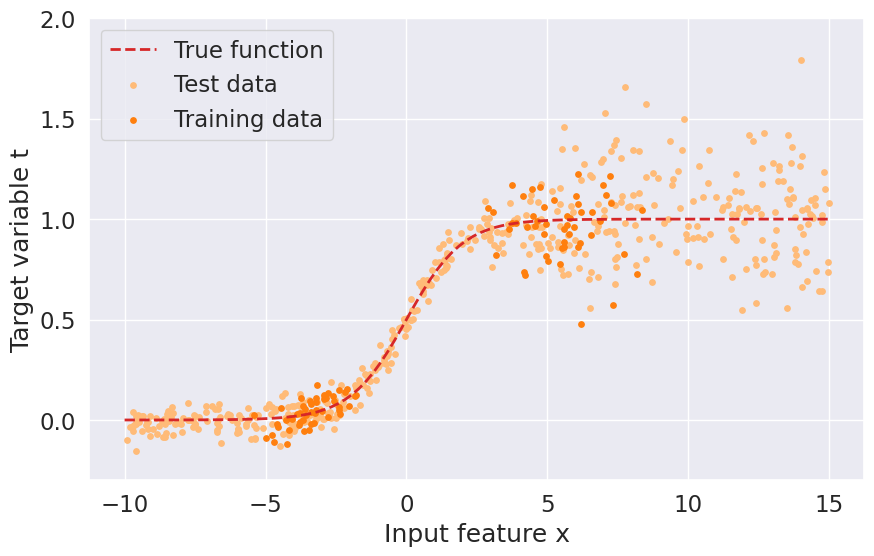

In [2]:
# load data
data = np.load('./ex13_toydata.npz')
X_train = data['X_train']
X_test = data['X_test']
Xp = data['Xp']
t_train = data['t_train']
t_test = data['t_test']


# the data is generating using a sigmoid as underlying signal
sigmoid = lambda x: 1/(1+np.exp(-x))
f = lambda x: sigmoid(x)


def plot_data(ax):
    ax.plot(Xp, f(Xp), color=plt.cm.tab20(6), ls="--", linewidth=2, label='True function')
    ax.scatter(X_test, t_test, s=15, color=plt.cm.tab20(3), label='Test data')
    ax.scatter(X_train, t_train, s=15, color=plt.cm.tab20(2), label='Training data')
    ax.set(xlabel='Input feature x', ylabel='Target variable t', ylim=(-0.3, 2))
    
# plot data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)
ax.legend()

**Task 1**: Complete the implementation of the log likelihood function below.

In [3]:
def log_npdf(x, m, v):
    return -0.5*(x-m)**2/v - 0.5*np.log(2*np.pi*v)

def log_lik_regression(y, t):
    """ implement the log likelihood in eq. (5)  for network outputs y and observations t
    
    inputs:
    y           --  output of neural network (np.array: N x 2)
    t           --  targets/observations     (np.array: N x 1)

    output:
    log_lik     --  sum of log likelihoods terms for observations in t (np.float64: scalar)

    """
    
    log_lik = np.sum(log_npdf(t, y[:, 0][:, None], np.exp(y[:, 1][:, None])))

    return log_lik


# simple sanity checks for your implementation
assert type(log_lik_regression(np.ones((len(t_train), 2)), t_train)) is np.float64, f"The output of log_lik_regression must be a scalar (float), but the output was {type(log_lik_regression(np.ones((len(t_train), 2)), t_train))}. Please verify that your implementation is correct."
assert np.allclose(log_lik_regression(np.ones((len(t_train), 2)), t_train), -150.62110358638134), f"The output of log_lik_regression must be  close to -150.62110358638134, but the output was {log_lik_regression(np.ones((len(t_train), 2)), t_train)}. Please verify that your implementation is correct."

The following cell will compute the MAP-solution of the neural network by optimizing the log joint distibution wrt. $\mathbf{w}$:

In [4]:
# specify architecture
num_inputs = 1
hidden1 = 20
hidden2 = 20
num_outputs = 2
network_shape = [num_inputs, hidden1, hidden2, num_outputs]

# create and train network
model_MAP = NeuralNetwork(X_train, t_train, network_shape, log_lik_regression, alpha=1., step_size=1e-2, batch_size=None, num_iters=2000, seed=0)

Itt = 200/2000 (10.0%), log joint = -550.99
Itt = 400/2000 (20.0%), log joint = -1149.04
Itt = 600/2000 (30.0%), log joint = -402.40
Itt = 800/2000 (40.0%), log joint = -401.80
Itt = 1000/2000 (50.0%), log joint = -400.37
Itt = 1200/2000 (60.0%), log joint = -398.47
Itt = 1400/2000 (70.0%), log joint = -396.19
Itt = 1600/2000 (80.0%), log joint = -394.31
Itt = 1800/2000 (90.0%), log joint = -393.55
Itt = 2000/2000 (100.0%), log joint = -391.69


We can now use the function `m.predict` to compute a forward pass through the network. That is, it evaluates $y(\mathbf{x})$ for the input points in the array `Xp` using $\mathbf{w}_{\text{MAP}}$:


In [5]:
pred = model_MAP.predict(Xp)
print(f'shape of Xp: {Xp.shape}')
print(f'shape of pred: {pred.shape}')

shape of Xp: (100, 1)
shape of pred: (100, 2)


The output variable `pred` is an $N \times 2$ array because the network has two outputs. 

For the MAP-method, we can compute the predictive mean and interval analytically.

**Task 2**: Plot the mean prediction and a $95%$ confidence interval for each point in the array Xp. 

*Hints*
- For each input point $\mathbf{x}$, we predict a mean value $\mu(\mathbf{x})$ and a variance $\sigma^2(\mathbf{x})$ of a Gaussian.
- A $95%$ confidence interval for a Gaussian $\mathcal{N}(x|m, v)$ is approximately $\left[m - 1.96\sqrt{v}, m + 1.96\sqrt{v}\right]$.
- The function `plt.fill_between` is handy for visualizing intervals.

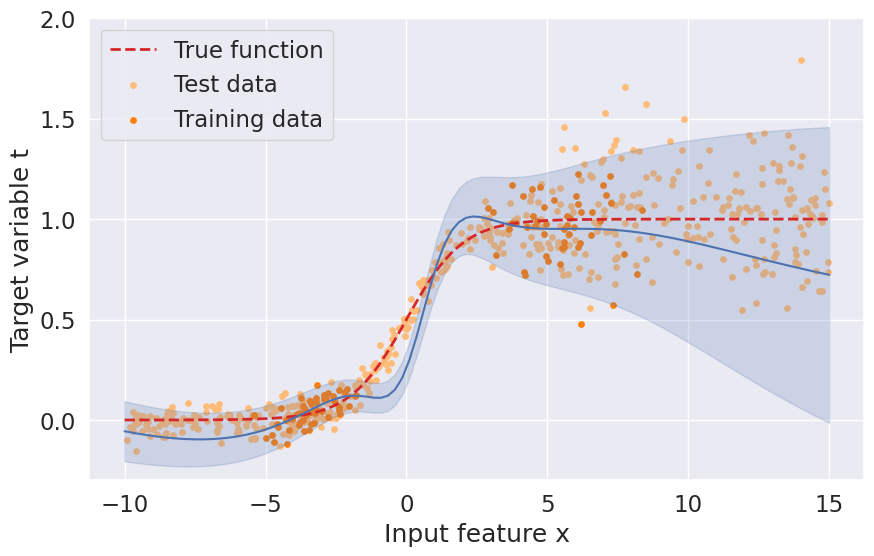

In [19]:
def extract_mean_and_var(pred, samples=False):
    if samples:
        return pred[:, :, 0], np.exp(pred[:, :, 1])
    else:
        return pred[:, 0], np.exp(pred[:, 1])

# separate mean and variance 
mu_MAP, v_MAP = extract_mean_and_var(pred)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)

### Add your solution to task 2 here ####
lower_MAP = mu_MAP - 1.96*np.sqrt(v_MAP)
upper_MAP = mu_MAP + 1.96*np.sqrt(v_MAP)

ax.plot(Xp, mu_MAP)
ax.fill_between(Xp.ravel(), lower_MAP, upper_MAP, color='b', alpha=0.2)

ax.legend()


***Question***

- How can you tell from the resulting fit that we have used a heteroscedastic model?
* The model uncertainty i.e. the confidence interval changes according to the input feature x i.e. it depends on x

Next, let's compute the average LPD for both the training and test set.

***Task 3***: Compute the average LPD for the training and the test sets.

*Hints*:
- Recall that $q_{\text{MAP}}(\mathbf{w}) = \delta(\mathbf{w}- \mathbf{w}_{\text{MAP}})$ and use eq. (4b) and (10).


In [13]:
### Solution to task 3 ###
# predict y values for training and test set
pred_train_MAP = model_MAP.predict(X_train)
pred_test_MAP = model_MAP.predict(X_test)

# extract mean and variance
mu_train_MAP, v_train_MAP = extract_mean_and_var(pred_train_MAP)
mu_test_MAP, v_test_MAP = extract_mean_and_var(pred_test_MAP)

# compute LPDs
LPD_train_MAP = np.mean(log_npdf(t_train, mu_train_MAP[:, None], v_train_MAP[:, None]))
LPD_test_MAP = np.mean(log_npdf(t_test, mu_test_MAP[:, None], v_test_MAP[:, None]))

# print
print(f'Train LPD MAP: {LPD_train_MAP:3.2f}')
print(f'Test LPD MAP: {LPD_test_MAP:3.2f}')

Train LPD MAP: 1.03
Test LPD MAP: -0.41


# Part 2: Last layer Laplace approximations (LLLA)

Next, we will study the last-layer Laplace approximation. The model class `NeuralNetwork` has two convenient functions for this purpose: `first_layers(params, X)` and `last_layer(param_last_layer, z)`, which implements $y_{1:L-1}$ and $y_L$, respectively. 

The cell below provides a simple implementation of LLLA. A couple of details of about the implementation:

 - The `model.params` variable stores all parameters of the network as a list: [[$\mathbf{W}_0, \mathbf{b}_0$], [$\mathbf{W}_1, \mathbf{b}_1$], [$\mathbf{W}_2, \mathbf{b}_2$]].
 - The function `flatten` takes a list of parameters as input and returns 1) a flattened version of the list (i.e. a vector), and 2) an `unflatten` function to the reverse this operation.
 - We need the parameters in flattened form to be able to compute the Hessian using autograd.


In [14]:
def compute_LLLA(model):
    """ compute last-layer Laplace approximation based on a pretrained model object with L layers """

    # get full list of parameters for network and extract parameters of last layer
    full_params = model.params
    last_params = full_params[-1]

    # flatten parameters of the last layer to prepare for the approximation
    w_last_flat, unflatten = flatten(last_params)

    # compute activation after first L-1 layers using input features and parameters
    z = model.first_layers(full_params, model.X)

    # prepare for Hessian computation by constructing function for evaluating the last layer of the neural network
    def last_layer_obj(w_):
        p = unflatten(w_)                       # unflatten
        y = model.last_layer(p, z)              # map through last layer
        return -model.log_lik_fun(y, model.t)

    # compute Hessian of log likelihood
    H_loglik = hessian(last_layer_obj)(w_last_flat)

    # comptue Hessian of log prior
    H_logprior = model.alpha * np.identity(len(w_last_flat))

    # compute Hessian of log joint
    H = H_loglik + H_logprior
    
    # can be done more efficiently depending on the Hessian approximation, but will be less transparent.
    S = np.linalg.inv(H)

    # return params of last layer (flattened), estimated covariance matrix, the estimated hessian and a function for unflatting the parameters
    return w_last_flat, S, H, unflatten


w_MAP_flat, S_LLLA, H, unflatten = compute_LLLA(model_MAP)


Thus, the array `w_MAP_flat` and  the matrix `S_LLLA` contain the mean and covariance of the posterior approximation of the last-layer, respectively.

***Task 4***: Fill in the missing pieces in the implementation below:

In [16]:
def predict_LLLA(X, model, w_LLLA_flat, S_LLLA, num_samples=1000):
    """ Computes the samples from the LLLA predictive distribution using a pretrained model object 
        and an LLLA approximation specificied by a mean vector w_LLLA_flat and a covariance matrix S_LLLA.
        B denotes the number of parameters in the last layer

    inputs:
    X            ---    input points (np.array: P x D)
    model        ---    NeuralNetwork object (pretrained) 
    w_LLLA_flat  ---    vector of mean parameters for the last layer (np.array: B x 1)
    S_LLLA_flat  ---    covarince matrix for the parameters of the last laeyr (np.array: (B x B))
    num_samples  ---    number of samples to generate for each input

    outputs:
    preds_LLLA   ---    samples from the predictive distribution for each input in X (np.array: num_samples x P x 2)
    """

    # feed input through first part of network
    z = model.first_layers(model.params, X)

    # first we will sample from the approximate posterior of the last layer
    w_samples = np.random.multivariate_normal(w_LLLA_flat, S_LLLA, size=num_samples)

    # compute predictions for each posterior sample
    preds_LLLA = np.stack([model.last_layer(unflatten(w_i), z) for w_i in w_samples])

    
    return preds_LLLA


# make predictions for plotting
preds_LLLA_pred = predict_LLLA(Xp, model_MAP, w_MAP_flat, S_LLLA)

# sanity check
assert(preds_LLLA_pred.shape == (1000, 100, 2)), f"The shape of preds_LLLA_pred must be (1000, 100, 2), but was found to be {preds_LLLA_pred.shape}. Go back and check your implementation."

# split into mean and variance
mu_LLLA_pred, v_LLLA_pred = extract_mean_and_var(preds_LLLA_pred, samples=True)
print(f'shape of mu_LLLA_pred: {mu_LLLA_pred.shape}')
print(f'shape of  v_LLLA_pred: {v_LLLA_pred.shape}')

shape of mu_LLLA_pred: (1000, 100)
shape of  v_LLLA_pred: (1000, 100)


The two arrays above now contains $S= 1000$ samples of the mean and variance of the Gaussian distribution for each of the 100 points in the array `Xp`. We can use those for plotting the predictive distribution.


In [17]:
def plot_predictions(ax, mean, variances, color='b', seed=0):
    """ Plot the predictive distribution (mean and 95% credibility interval) obtained.
        Below, S denotes the number of samples and P denoted the number of points. For each of the S samples and
        for each of the P points, the function generates a sample from corresponding Normal distribution and computes the mean and 95% interval and plots it on ax.
        
    inputs:
    ax          -- axis object for plotting
    mean        -- array of mean values (np.array: S x P)
    variances   -- array of variance values (np.array: S x P)

    """

    np.random.seed(seed)
    f = np.random.normal(mean, np.sqrt(variances))
    f_mean  = np.mean(f, axis=0)
    f_lower = np.percentile(f, 2.5, axis=0)
    f_upper = np.percentile(f, 97.5, axis=0)

    ax.plot(Xp, f_mean, color=color)
    ax.fill_between(Xp.ravel(), f_lower, f_upper, alpha=0.2, color=color)

Let's compare the predictions for MAP and LLLA:

Text(0.5, 1.0, 'Predictive uncertainty for LLLA')

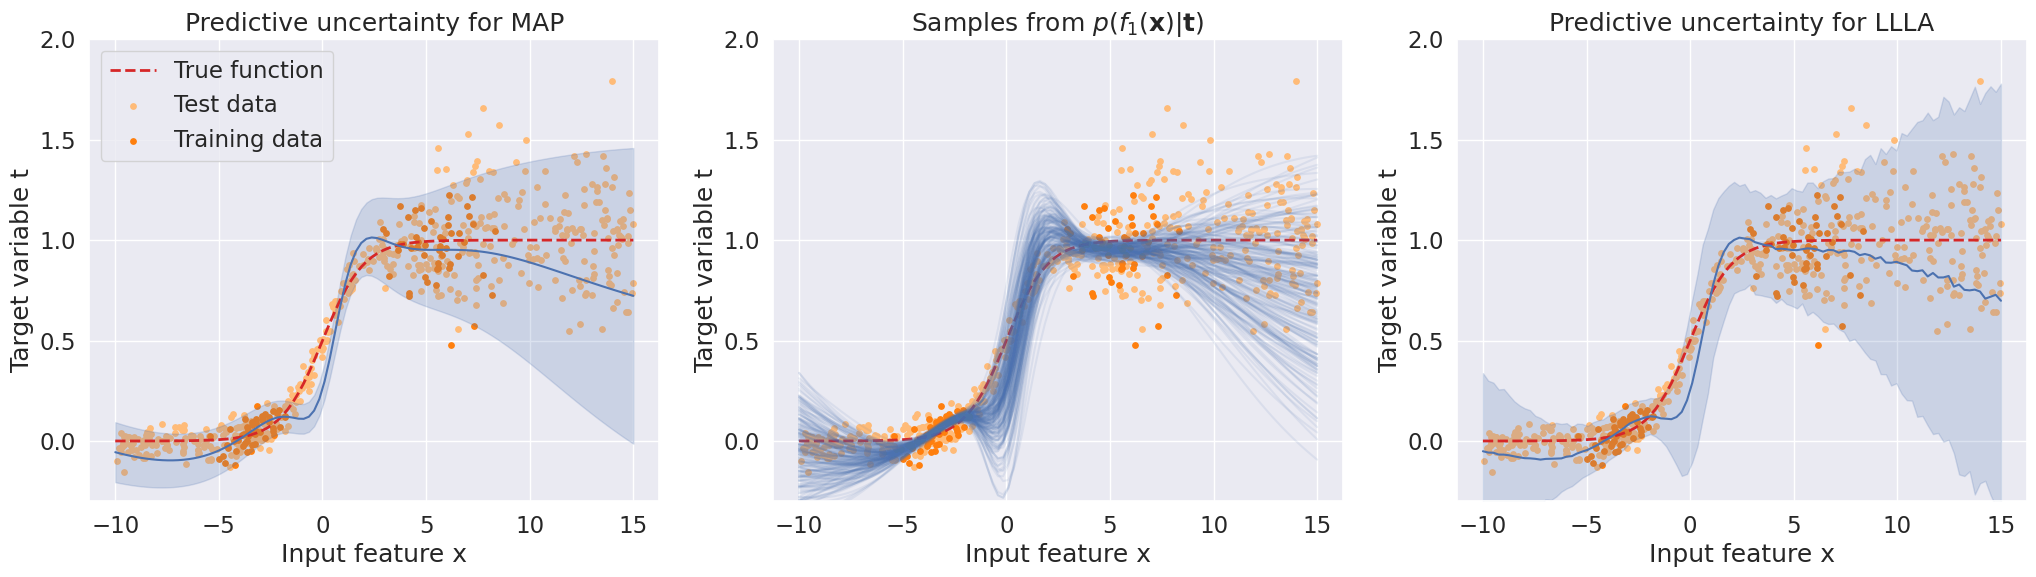

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

# left
plot_data(ax[0])
ax[0].plot(Xp, mu_MAP)
ax[0].fill_between(Xp.ravel(), lower_MAP, upper_MAP, color='b', alpha=0.2)
ax[0].legend()
ax[0].set_title('Predictive uncertainty for MAP')

# center
plot_data(ax[1])
ax[1].plot(Xp, mu_LLLA_pred[:200, :].T, 'b', alpha=0.1);
ax[1].set_title('Samples from $p(f_1(\mathbf{x})|\mathbf{t})$')

# right
plot_data(ax[2])
plot_predictions(ax[2], mu_LLLA_pred, v_LLLA_pred)
ax[2].set_title('Predictive uncertainty for LLLA')

***Questions*** 
- Comment on the resulting fits. How does the MAP and LLLA compare?
    * The LLLA model includes epistemic uncertainty that we have in the model parameters compared to MAP where we go with a point estimate of model parameters
    * The LLLA model has higher uncertainty in the test data area, which makes sense, since we do not have any data and therefore we should be uncertain if our weights are correct for fitting the data
- How well do the models fit in region with training data and in regions without training data? Does the uncertainty look reasonable?
  - Reasonable for the LLLA, but the MAP model is too confident. Shoul have wider confidence interval, when no observations i.e. should include epistemic variance
- Which of the three plots visualizes (some degree of) aleatoric uncertainty, epistemic uncertainty or a combination?
    * Plot 1 aleatoric uncertainty, Plot 2 epistemic uncertainty from sampling functions (weights) from the LLLA, Plot 3 epistemic and aleatoric uncertainty combined in LLLA


Let's now compute the training and test LPD for LLLA.

***Task 5***: Compute the average LPD for the training and test set for the LLLA approximation.

In [21]:
npdf = lambda x, m, v: np.exp(log_npdf(x, m, v))

### Solution to task 5 ###

# predict with network
preds_LLLA_train = predict_LLLA(X_train, model_MAP, w_MAP_flat, S_LLLA)
preds_LLLA_test = predict_LLLA(X_test, model_MAP, w_MAP_flat, S_LLLA)

# extract mean and variance
mu_LLLA_train, v_LLLA_train = extract_mean_and_var(preds_LLLA_train, samples=True)
mu_LLLA_test, v_LLLA_test = extract_mean_and_var(preds_LLLA_test, samples=True)

# implement eq. (9)
LPD_train_LLLA = np.mean(np.log(np.mean(npdf(t_train.ravel(), mu_LLLA_train, v_LLLA_train), axis=0)))
LPD_test_LLLA = np.mean(np.log(np.mean(npdf(t_test.ravel(), mu_LLLA_test, v_LLLA_test), axis=0)))

print(f'LPD train LLLA: {LPD_train_LLLA:3.2f}')
print(f'LPD test LLLA: {LPD_test_LLLA:3.2f}')

LPD train LLLA: 1.03
LPD test LLLA: 0.42


***Questions***
- How does the LLLA approximation compare with the MAP solution in terms of LPD?
    * Much better on the test set than the MAP
- How does the LLLA approximation compare with MAP in terms of computational cost?
    * It is more heavy computationally than MAP, but only a little because you just add the computaiton with the Hessian on the last layer

# Part 3: Deep ensembles

Finally, we will implement a deep ensemble with 10 models and compare to MAP and LLLA.

Below you are given a simple template for implementing a deep ensemble:



In [22]:
class DeepEnsemble(object):

    def __init__(self):
        self.models = []
        self.num_models = 0

    def add_model(self, model):
        """ # add pretrained model"""
        self.models.append(model)
        self.num_models = len(self.models)
        
    def predict_single(self, Xp, idx_model):
        """ predict using a single model in the ensemble """
        return self.models[idx_model].predict(Xp)

    def predict(self, Xp, subset_models=None):
        # use all models in the ensemble or only a subset?
        if subset_models is None:
            list_of_models = range(self.num_models)
        else:
            list_of_models = range(subset_models)

        # compute and return predictions for each model
        return [self.predict_single(Xp, idx_model) for idx_model in list_of_models ]

    def sample_predictive_dist(self, Xp, subset_models=None, num_samples=1000):
        """ predict using all models in the ensemble (or a subset of them) """

        # make predictions for models
        preds = self.predict(Xp, subset_models)

        # sample predictive distribution for each model
        t_samples = []
        for idx_model in range(len(preds)):
            mu, var = extract_mean_and_var(preds[idx_model])
            t = np.random.normal(mu, np.sqrt(var), size=(num_samples, len(mu)))
            t_samples.append(t)
    
        # ... and concate the results
        return np.concatenate(t_samples, axis=0)
    
# prepare deep ensemble
num_models = 10
ensemble_model = DeepEnsemble()
for idx_model in range(num_models):
    print(f'Training model {idx_model+1}/{num_models}')
    ensemble_model.add_model(NeuralNetwork(X_train, t_train, network_shape, log_lik_regression, alpha=1., step_size=1e-2, batch_size=None, num_iters=2000, seed=idx_model))


Training model 1/10
Itt = 200/2000 (10.0%), log joint = -550.99
Itt = 400/2000 (20.0%), log joint = -1149.04
Itt = 600/2000 (30.0%), log joint = -402.40
Itt = 800/2000 (40.0%), log joint = -401.80
Itt = 1000/2000 (50.0%), log joint = -400.37
Itt = 1200/2000 (60.0%), log joint = -398.47
Itt = 1400/2000 (70.0%), log joint = -396.19
Itt = 1600/2000 (80.0%), log joint = -394.31
Itt = 1800/2000 (90.0%), log joint = -393.55
Itt = 2000/2000 (100.0%), log joint = -391.69
Training model 2/10
Itt = 200/2000 (10.0%), log joint = -401.11
Itt = 400/2000 (20.0%), log joint = -391.23
Itt = 600/2000 (30.0%), log joint = -387.60
Itt = 800/2000 (40.0%), log joint = -393.09
Itt = 1000/2000 (50.0%), log joint = -384.14
Itt = 1200/2000 (60.0%), log joint = -384.94
Itt = 1400/2000 (70.0%), log joint = -381.09
Itt = 1600/2000 (80.0%), log joint = -396.87
Itt = 1800/2000 (90.0%), log joint = -377.45
Itt = 2000/2000 (100.0%), log joint = -376.68
Training model 3/10
Itt = 200/2000 (10.0%), log joint = -396.51
I

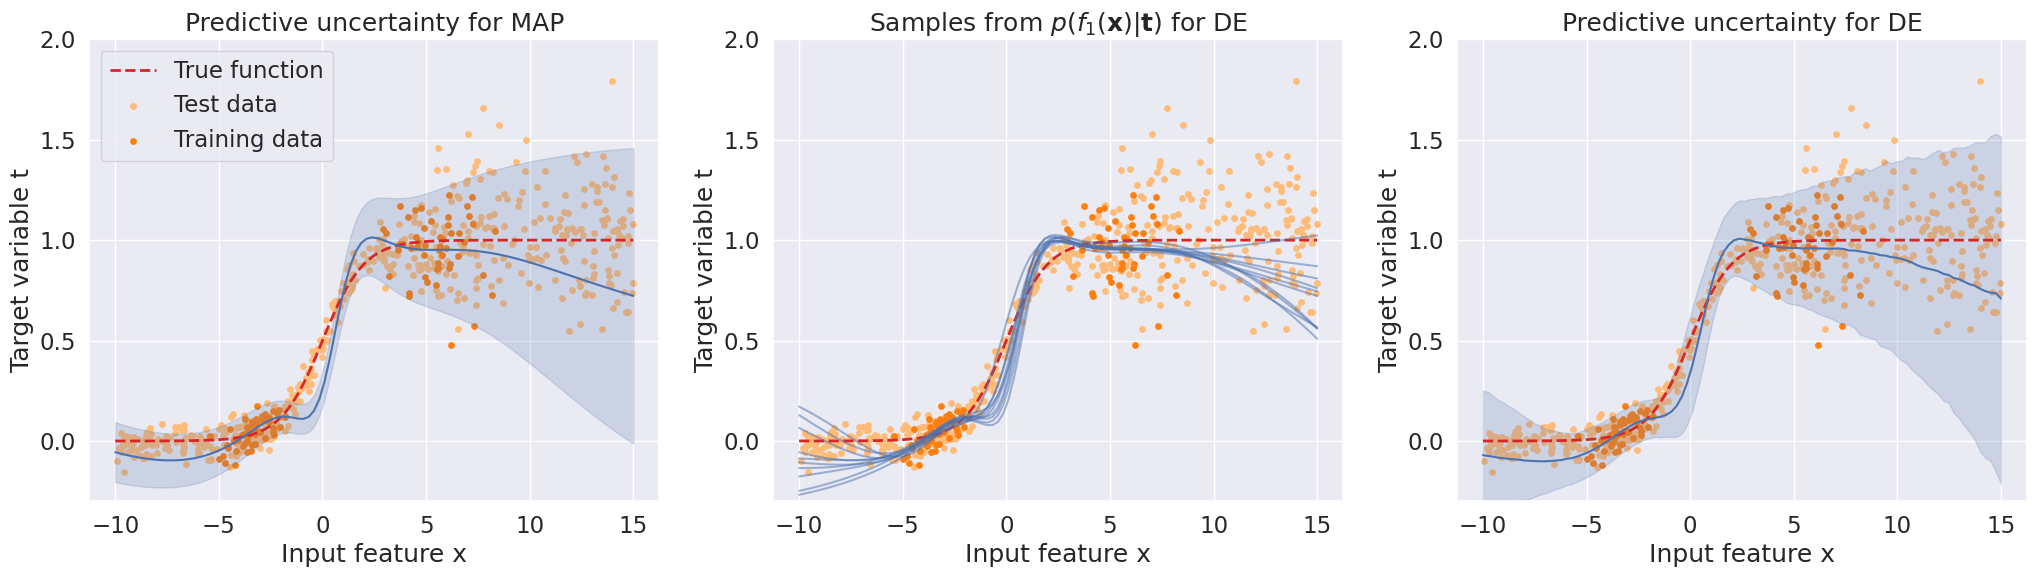

In [23]:
# compute predictions for all models in the ensemble
preds = ensemble_model.predict(Xp)

# extract mean predictions from individual models for plotting purposes
mu_ensemble = extract_mean_and_var(np.stack(preds), True)[0]

# generate samples from the predictive distribution
t_samples_ensemble = ensemble_model.sample_predictive_dist(Xp)

# compute mean and 95% interval
t_mean_ensemble = np.mean(t_samples_ensemble, axis=0)
lower_ensemble, upper_ensemble = np.percentile(t_samples_ensemble, 2.5, axis=0), np.percentile(t_samples_ensemble, 97.5, axis=0)

# plot
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

# left
plot_data(ax[0])
ax[0].set_title('Predictive uncertainty for MAP')
ax[0].plot(Xp, mu_MAP)
ax[0].fill_between(Xp.ravel(), lower_MAP, upper_MAP, color='b', alpha=0.2)
ax[0].legend()

# center
plot_data(ax[1])
ax[1].set_title('Samples from $p(f_1(\mathbf{x})|\mathbf{t})$ for DE')
ax[1].plot(Xp, mu_ensemble.T, 'b', alpha=0.5);

# right
plot_data(ax[2])
ax[2].set_title('Predictive uncertainty for DE')
ax[2].plot(Xp, t_mean_ensemble)
ax[2].fill_between(Xp.ravel(), lower_ensemble, upper_ensemble, color='b', alpha=0.2)


***Questions***

- How does the DE approximation compare qualitatively to the MAP solution? In regions with training data? In regions without training data?
    * Looks like the MAP solution in areas with observations and adds extra epistemic uncertainty in the test area without observations

***Task 6***: Compute the average log predictive density for the training and test set for the deep ensemble.

*hints*:
- Use equation (4) and (10)

In [24]:
### Solution task 6 ###
def log_predictive_ensemble(ensemble, Xp, tp, subset_models=None):
    """ evaluate log predictive for points (Xp, tp) """

    # make predictions for models
    preds = ensemble.predict(Xp, subset_models)

    fs = []
    for idx_model in range(len(preds)):
        mu, var = extract_mean_and_var(preds[idx_model])
        fs.append(npdf(tp, mu[:, None], var[:, None]))

    fs = np.stack(fs)

    return np.mean(np.log(np.mean(fs, axis=0)))



LPD_train_ensemble = log_predictive_ensemble(ensemble_model, X_train, t_train)
LPD_test_ensemble = log_predictive_ensemble(ensemble_model,X_test, t_test)

print(f'LPD train DE: {LPD_train_ensemble:3.2f}')
print(f'LPD test DE: {LPD_test_ensemble:3.2f}')

LPD train DE: 1.03
LPD test DE: 0.45


***Questions***

- How do the three methods compare in terms of LPD for the toy data?
    * Deep Ensemble and LLLA are better on the test data than MAP
    * Deep Ensemble is a little better than LLLA, but compared to the increase in computational cost in Deep Ensemble then LLLA might be the best choice

# Part 4: Modelling the Concrete dataset from the UCI repository

In this part, we will test this model with three types of inference: MAP, LLLA and DE on a real dataset. We will work with the Concrete dataset from the UCI repository.

The goal is to predict the strength of concrete based on a set of input features. See the link below for more information:

[https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)

The dataset has $N = 1030$ observations in total and the input features are $D = 8$ dimensional.

We will use a 90/10 split for training and testing.

Let's load and prepare the data using pandas:

In [25]:
# we will load to data using pandas

import pandas as pd
df = pd.read_csv('./concrete_data.csv')

# prepare data
X = df.to_numpy()
t = X[:, -1]
X = X[:, :-1]

# sizes
N, D = X.shape
Ntest = int(0.1*N)

# split into training and test
np.random.seed(0)
test_idx = np.random.choice(range(N), size=Ntest, replace=False)
train_idx = np.setdiff1d(range(N), test_idx)

X_train = X[train_idx, :]
X_test = X[test_idx, :]
t_train = t[train_idx][:, None]
t_test = t[test_idx][:, None]

# standardize input features
Xm, Xs = np.mean(X_train, 0), np.std(X_train, 0)
X_train = (X_train - Xm)/Xs
X_test = (X_test - Xm)/Xs

Your job is now to repeat the analysis from part 1-3 for this data set. 

Use $\alpha = 1$, a step size of $10^{-2}$, a batch size of $50$, and $10000$ training iterations for these experiments and the same network architecture as above.

***Task 7***: Fit a MAP-network to the data

In [26]:
### Solution to task 7 ###
m_MAP = NeuralNetwork(X_train, t_train, [D, 20, 20, 2], log_lik_regression, alpha=1., step_size=1e-2, batch_size=50, num_iters=10000)

Itt = 1000/10000 (10.0%), log joint = -5214.16
Itt = 2000/10000 (20.0%), log joint = -5005.86
Itt = 3000/10000 (30.0%), log joint = -4690.73
Itt = 4000/10000 (40.0%), log joint = -4350.54
Itt = 5000/10000 (50.0%), log joint = -3864.04
Itt = 6000/10000 (60.0%), log joint = -3653.75
Itt = 7000/10000 (70.0%), log joint = -3519.24
Itt = 8000/10000 (80.0%), log joint = -3412.90
Itt = 9000/10000 (90.0%), log joint = -3388.72
Itt = 10000/10000 (100.0%), log joint = -3289.04


***Task 8***: Compute the training and test average LPD using the MAP solution.

In [27]:
### Solution to task 8 ###
pred_train_MAP = m_MAP.predict(X_train)
pred_test_MAP = m_MAP.predict(X_test)

pred_train_mu, pred_train_var = extract_mean_and_var(pred_train_MAP)
pred_test_mu, pred_test_var = extract_mean_and_var(pred_test_MAP)

def compute_log_predictive(t, mu, v):
    npdf_vals = npdf(t, mu[:, None], v[:, None])
    return np.mean(np.log(npdf_vals))

LPD_train_MAP = compute_log_predictive(t_train, pred_train_mu, pred_train_var)
LPD_test_MAP = compute_log_predictive(t_test, pred_test_mu, pred_test_var)

print(f'LPD Train: {LPD_train_MAP:3.2f}')
print(f'LPD test: {LPD_test_MAP:3.2f}')

LPD Train: -2.68
LPD test: -3.90


***Task 9***: Use the MAP solution to compute an LLLA approximation.

In [28]:
### Solution to task 9 ###
w_MAP_flat, S_LLLA, H, unflatten = compute_LLLA(m_MAP)

***Task 10***: Compute the average training and test LPD for the LLLA solution.

In [29]:
### Solution to task 10 ###
# predict with network
preds_LLLA_train = predict_LLLA(X_train, m_MAP, w_MAP_flat, S_LLLA)
preds_LLLA_test = predict_LLLA(X_test, m_MAP, w_MAP_flat, S_LLLA)

# extract mean and variance
mu_LLLA_train, v_LLLA_train = extract_mean_and_var(preds_LLLA_train, samples=True)
mu_LLLA_test, v_LLLA_test = extract_mean_and_var(preds_LLLA_test, samples=True)

# implement eq. (9)
LPD_train_LLLA = np.mean(np.log(np.mean(npdf(t_train.ravel(), mu_LLLA_train, v_LLLA_train), axis=0)))
LPD_test_LLLA = np.mean(np.log(np.mean(npdf(t_test.ravel(), mu_LLLA_test, v_LLLA_test), axis=0)))

print(f'LPD train LLLA: {LPD_train_LLLA:3.2f}')
print(f'LPD test LLLA: {LPD_test_LLLA:3.2f}')


LPD train LLLA: -2.68
LPD test LLLA: -3.25


***Task 11***: Fit a deep ensemble with 10 models (it may take a little while to run, so start with a smaller number and increase the number of models when you are sure that everything is correct).

In [30]:
### Solution to task 11 ###

num_models = 10
ensemble_model = DeepEnsemble()
for idx_model in range(num_models):
    print(f'Training model {idx_model+1}/{num_models}')
    ensemble_model.add_model(NeuralNetwork(X_train, t_train, [D, 20, 20, 2], log_lik_regression, alpha=1., step_size=1e-2, batch_size=50, num_iters=10000, seed=idx_model))

Training model 1/10
Itt = 1000/10000 (10.0%), log joint = -5167.50
Itt = 2000/10000 (20.0%), log joint = -4916.18
Itt = 3000/10000 (30.0%), log joint = -4595.04
Itt = 4000/10000 (40.0%), log joint = -4181.32
Itt = 5000/10000 (50.0%), log joint = -3805.33
Itt = 6000/10000 (60.0%), log joint = -3615.00
Itt = 7000/10000 (70.0%), log joint = -3495.24
Itt = 8000/10000 (80.0%), log joint = -3362.35
Itt = 9000/10000 (90.0%), log joint = -3316.82
Itt = 10000/10000 (100.0%), log joint = -3244.73
Training model 2/10
Itt = 1000/10000 (10.0%), log joint = -5391.62
Itt = 2000/10000 (20.0%), log joint = -5251.38
Itt = 3000/10000 (30.0%), log joint = -5156.77
Itt = 4000/10000 (40.0%), log joint = -5010.73
Itt = 5000/10000 (50.0%), log joint = -4786.12
Itt = 6000/10000 (60.0%), log joint = -4578.03
Itt = 7000/10000 (70.0%), log joint = -4079.65
Itt = 8000/10000 (80.0%), log joint = -3788.44
Itt = 9000/10000 (90.0%), log joint = -3647.06
Itt = 10000/10000 (100.0%), log joint = -3484.31
Training model 3

***Task 12***: Evaluate the training and test LPDs for the DE.


In [31]:
### Solution to task 12 ###

# we will use the function from the solution of task 6
LPD_train_ensemble = log_predictive_ensemble(ensemble_model, X_train, t_train)
LPD_test_ensemble = log_predictive_ensemble(ensemble_model, X_test, t_test)

print(f'LPD train DE: {LPD_train_ensemble:3.2f}')
print(f'LPD test DE: {LPD_test_ensemble:3.2f}')

LPD train DE: -2.55
LPD test DE: -2.98


**Questions**: Which of the three methods (MAP, LLLA, DE) works best for this data set?
    * Best is DE, LLA a little better than MAP on test

**Task 13**: Plot the performance as a function of the number of models in the ensemble.

*hints*
- First compute predictions for an ensemble with $S = 1$ model (i.e. the MAP solution), then $S = 2$, $S = 3$ etc.
- You only need to fit your ensemble once. After you've fitted the ensemble you can make predictions using subsets of the models using the `subset_models` argument to the `predict` function.

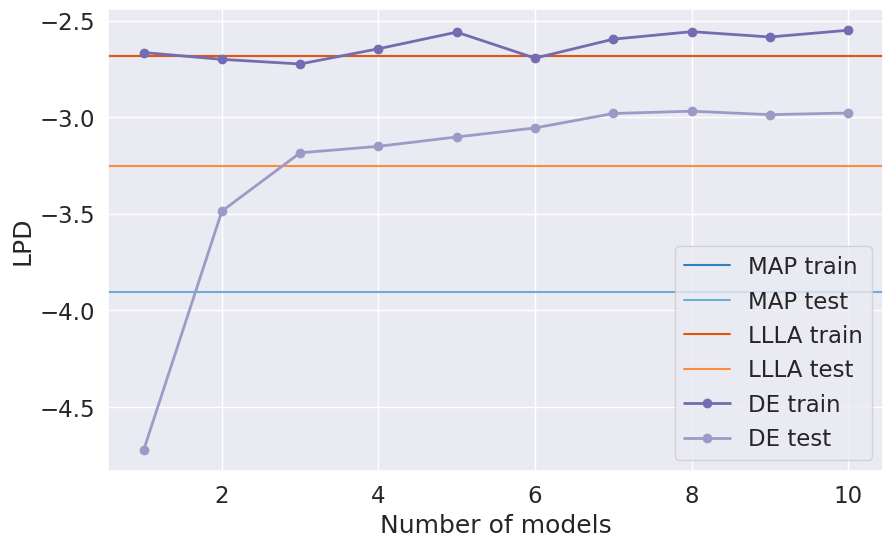

In [32]:
### Solution task 13 ###
LPD_train_ensemble_subset = []
LPD_test_ensemble_subset = []

model_range = np.arange(1, ensemble_model.num_models+1)

for i in model_range:
    LPD_train_ensemble_subset.append(log_predictive_ensemble(ensemble_model, X_train, t_train, subset_models=i))
    LPD_test_ensemble_subset.append(log_predictive_ensemble(ensemble_model, X_test, t_test, subset_models=i))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# MAP performance
ax.axhline(LPD_train_MAP, color=plt.cm.tab20c(0), linestyle='-', label='MAP train')
ax.axhline(LPD_test_MAP, color=plt.cm.tab20c(1), linestyle='-', label='MAP test')

# LLLA performance
ax.axhline(LPD_train_LLLA, color=plt.cm.tab20c(4), linestyle='-', label='LLLA train')
ax.axhline(LPD_test_LLLA, color=plt.cm.tab20c(5), linestyle='-', label='LLLA test')

# DE performance 
ax.plot(model_range, LPD_train_ensemble_subset, color=plt.cm.tab20c(12), marker='o', linestyle='-', label='DE train', linewidth=2)
ax.plot(model_range, LPD_test_ensemble_subset, color=plt.cm.tab20c(13), marker='o', linestyle='-', label='DE test', linewidth=2)

# labels etc
ax.set(xlabel='Number of models', ylabel='LPD')
ax.legend()